<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4/blob/main/SP/Spectrum_measurements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import altair as alt
import pandas as pd

In [25]:
URL_H = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab4/refs/heads/main/SP/hydrogen_1701237U1.TXT'
URL_Hg = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab4/refs/heads/main/SP/mercury_1701237U1.TXT'
lm, counts = np.loadtxt(URL_H, delimiter=';', skiprows=8, usecols=[0,4], unpack=True)
intensity = np.log(counts)

<ipython-input-25-542e7a6d7fe5>:4: RuntimeWarning: divide by zero encountered in log
  intensity = np.log(counts)
<ipython-input-25-542e7a6d7fe5>:4: RuntimeWarning: invalid value encountered in log
  intensity = np.log(counts)


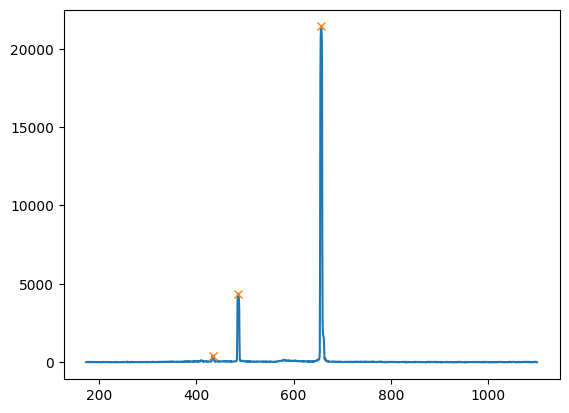

In [39]:
peaks, _ = find_peaks(counts, height=200, prominence=100)
plt.plot(lm, counts)
plt.plot(lm[peaks], counts[peaks], 'x')
plt.show()

In [42]:
source = pd.DataFrame({
    'lm': lm,
    'counts': counts,
    'intensity': intensity
})

graph = alt.Chart(source).mark_line().encode(
    x='lm',
    y=alt.Y('counts'),
    tooltip=['lm', 'counts']
).interactive()

callout = alt.Chart(source.iloc[peaks]).mark_point(
    color='red', size=300, tooltip="Tooltip text here"
).encode(
    x='lm',
    y='counts'
)

print(lm[peaks])

graph + callout

[434.03 486.08 656.9 ]


alt.LayerChart(...)